### Imports

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional, Dict, Any
from PIL import Image
from tqdm import tqdm
from torchview import draw_graph
import umap
from sklearn.manifold import TSNE
from torch.nn.functional import cosine_similarity

from plotly_tools import *
import plotly.express as px
from pathlib import Path
import torch
from transformers import AlignModel, AlignProcessor, AlignTextConfig, AlignVisionConfig

os.environ["HF_HOME"] = "../.hf_home"
random_seed = 42
torch.manual_seed(random_seed)
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


### Load Model & Processor

In [2]:
model = AlignModel.from_pretrained("kakaobrain/align-base", cache_dir=os.environ["HF_HOME"])
processor = AlignProcessor.from_pretrained("kakaobrain/align-base", cache_dir=os.environ["HF_HOME"])
config_vision = AlignVisionConfig.from_pretrained("kakaobrain/align-base", cache_dir=os.environ["HF_HOME"])
config_text = AlignTextConfig.from_pretrained("kakaobrain/align-base", cache_dir=os.environ["HF_HOME"])

text_model = model.text_model
vision_model = model.vision_model
text_projection = model.text_projection

#### Switch model to eval mode

In [3]:
_ = model.eval()
_ = text_model.eval()
_ = vision_model.eval()
_ = text_projection.eval()

### Model architecture exploration

#### Image Size & Text Length

In [4]:
text_model.config.max_position_embeddings, processor.tokenizer.model_max_length, vision_model.config.image_size

(512, 64, 289)

#### Tokenizer / Text Embedding

In [5]:
processor.tokenizer

BertTokenizerFast(name_or_path='kakaobrain/align-base', vocab_size=30522, model_max_length=64, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [6]:
target_sentence = "a photo of a cat"
processor.tokenizer.tokenize(target_sentence)

['a', 'photo', 'of', 'a', 'cat']

In [7]:
cut_len = 15
tokenized = processor.tokenizer(target_sentence, return_tensors="pt", padding="max_length")

print(f"""Input IDs: \t\t{torch.flatten(tokenized.input_ids).tolist()[:cut_len]}
Attention Mask: \t{torch.flatten(tokenized.attention_mask).tolist()[:cut_len]}
Token Type IDs: \t{torch.flatten(tokenized.token_type_ids).tolist()[:cut_len]}
Total Length: \t\t{tokenized.input_ids.shape[1]}""")

Input IDs: 		[101, 1037, 6302, 1997, 1037, 4937, 102, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask: 	[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Token Type IDs: 	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total Length: 		64


In [8]:
with torch.no_grad():
    text_model_out = text_model(**tokenized)
text_model_out.pooler_output.shape

torch.Size([1, 768])

In [9]:
text_embedding = text_projection(text_model_out.pooler_output)
text_embedding.shape

torch.Size([1, 640])

#### Image Processing & Image Embedding

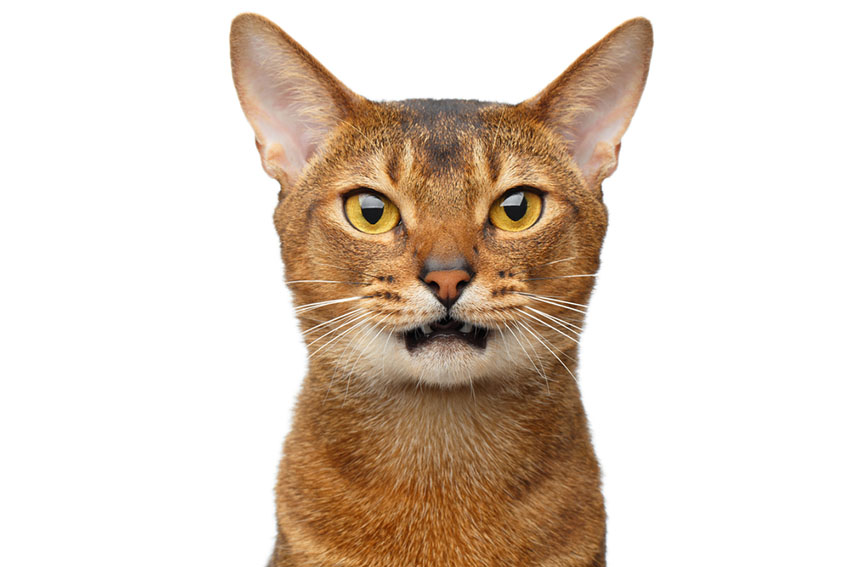

In [10]:
image = Image.open("sample_images/cat.jpg").convert("RGB")
image

In [11]:
processor.image_processor

EfficientNetImageProcessor {
  "crop_size": {
    "height": 289,
    "width": 289
  },
  "do_center_crop": true,
  "do_normalize": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "EfficientNetImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "include_top": false,
  "processor_class": "AlignProcessor",
  "resample": 2,
  "rescale_factor": 0.00784313725490196,
  "rescale_offset": true,
  "size": {
    "height": 346,
    "width": 346
  }
}

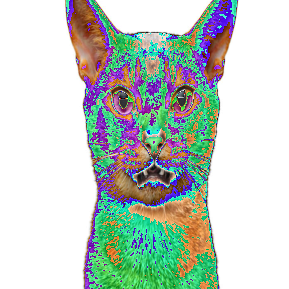

torch.Size([1, 3, 289, 289])

In [12]:
processed_image = processor.image_processor(images=image, return_tensors="pt")
display(Image.fromarray(np.uint8(processed_image.pixel_values[0].permute(1, 2, 0).numpy() * 255)))
processed_image.pixel_values.shape

In [13]:
with torch.no_grad():
    vision_model_out = vision_model(**processed_image)
vision_embedding = vision_model_out.pooler_output
vision_embedding.shape

torch.Size([1, 640])

#### Model Pipeline Visualization

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


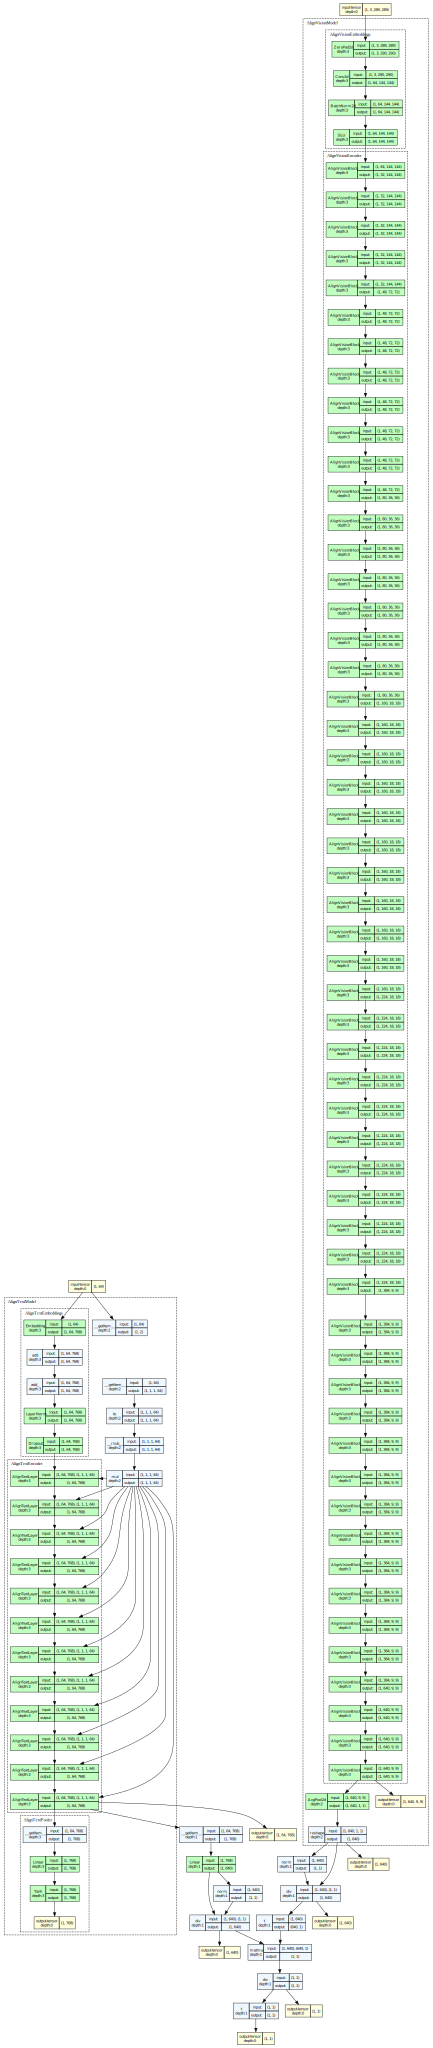

In [14]:
graph = draw_graph(model, input_size=[(1,64), (1,3,289,289)], dtypes=[torch.long, torch.float32], expand_nested=True)
graph.visual_graph

### Helper Functions

In [15]:
def embed_image_batch(image: List[Image.Image]) -> List[torch.Tensor]:
    model.to(device)
    inputs = processor(images=image, return_tensors="pt", padding="max_length").to(device)
    with torch.no_grad():
        image_embeddings = model.get_image_features(**inputs)
    return image_embeddings.cpu().numpy().tolist()


def embed_text_batch(text: List[str]) -> List[torch.Tensor]:
    model.to(device)
    inputs = processor(text=text, return_tensors="pt", padding="max_length").to(device)
    with torch.no_grad():
        text_embeddings = model.get_text_features(**inputs)
    return text_embeddings.cpu().numpy().tolist()

def load_images(paths: List[Path]) -> List[Image.Image]:
    images = []
    for path in paths:
        try:
            img = Image.open(path).convert("RGB")
            images.append(img)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    return images

def normalize_embeddings(embeddings: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    return embeddings / norms

### Run Inference on Custom Images and Captions

In [16]:
inference_needed = not os.path.exists("./processed_data.parquet")
print(f"Running inference: {inference_needed}")

Running inference: False


In [17]:
images_dir = "sample_images"
if inference_needed:
    df_lst = []
    for directory in os.listdir(images_dir):
        if not os.path.isdir(os.path.join(images_dir, directory)):
            continue

        img_cls = directory
        rel_path = os.path.join(images_dir, directory)

        img_paths = [os.path.join(rel_path, img_name) for img_name in os.listdir(rel_path) if not '.' in img_name]
        img_paths.sort()

        df_lst.append(pd.DataFrame({
            "image_path": img_paths,
            "class": [img_cls] * len(img_paths),
            "image_embedding": [None] * len(img_paths),
            "text_embedding": [None] * len(img_paths),
        }))

    df_embeddings = pd.concat(df_lst, ignore_index=True)
    del df_lst

In [18]:
batch_size = 128
if inference_needed:
    unique_class = df_embeddings['class'].unique().tolist()
    class_embedding_mapping = {v: e for v, e in zip(unique_class, embed_text_batch(unique_class))}
    df_embeddings['text_embedding'] = df_embeddings['class'].map(class_embedding_mapping)

    img_embeddings = []
    for i in tqdm(range(0, len(df_embeddings), batch_size)):
        batch_df = df_embeddings.iloc[i:i+batch_size]
        batch_images = load_images(batch_df['image_path'].tolist())
        batch_embeddings = embed_image_batch(batch_images)
        img_embeddings.extend(batch_embeddings)
        del batch_images, batch_embeddings, batch_df
        torch.mps.empty_cache()
    df_embeddings['image_embedding'] = img_embeddings
    del img_embeddings

### Save / Load Embeddings

In [19]:
if inference_needed:
    df_embeddings.to_parquet("processed_data.parquet", index=False, compression="brotli", engine="fastparquet")
else:
    df_embeddings = pd.read_parquet("processed_data.parquet", engine="fastparquet", index=False)

### Visualize Embeddings

#### Get Image

In [20]:
df_embeddings['image'] = df_embeddings['image_path'].apply(lambda x: Image.open(x).convert("RGB"))

/Users/riverfog7/Workspace/AISogang/.venv/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#### Normalize Embeddings

In [21]:
df_embeddings['image_embedding_normalized'] = normalize_embeddings(np.asarray(df_embeddings['image_embedding'].tolist())).tolist()
df_embeddings['text_embedding_normalized'] = normalize_embeddings(np.asarray(df_embeddings['text_embedding'].tolist())).tolist()
df_embeddings.head()

,image_path,class,image_embedding,text_embedding,image,image_embedding_normalized,text_embedding_normalized
0,sample_images/a snowy landscape/0,a snowy landscape,"[-0.08468000590801239, 7.830726099200547e-05, ...","[161.79830932617188, 604.0810546875, -1567.664...",<PIL.Image.Image image mode=RGB size=275x183 a...,"[-0.010425430014996604, 9.640845679971549e-06,...","[0.0034131352822886368, 0.012743089650953028, ..."
1,sample_images/a snowy landscape/1,a snowy landscape,"[0.1461774855852127, -0.3220600187778473, -0.1...","[161.79830932617188, 604.0810546875, -1567.664...",<PIL.Image.Image image mode=RGB size=251x201 a...,"[0.018266295814840065, -0.04024452568449578, -...","[0.0034131352822886368, 0.012743089650953028, ..."
2,sample_images/a snowy landscape/10,a snowy landscape,"[-0.1331758350133896, -0.5120929479598999, -0....","[161.79830932617188, 604.0810546875, -1567.664...",<PIL.Image.Image image mode=RGB size=364x138 a...,"[-0.016795421640576152, -0.06458241451452067, ...","[0.0034131352822886368, 0.012743089650953028, ..."
3,sample_images/a snowy landscape/100,a snowy landscape,"[-0.022138524800539017, 0.001311949803493917, ...","[161.79830932617188, 604.0810546875, -1567.664...",<PIL.Image.Image image mode=RGB size=275x183 a...,"[-0.002747470292205861, 0.00016281767382608496...","[0.0034131352822886368, 0.012743089650953028, ..."
4,sample_images/a snowy landscape/101,a snowy landscape,"[-0.12955859303474426, 0.23342949151992798, -0...","[161.79830932617188, 604.0810546875, -1567.664...",<PIL.Image.Image image mode=RGB size=284x177 a...,"[-0.015287524207718345, 0.027543977738699956, ...","[0.0034131352822886368, 0.012743089650953028, ..."


#### Compute Dimensionality Reduction

##### t-SNE

In [22]:
tnse = TSNE(n_components=3, random_state=random_seed, init='random', learning_rate='auto', perplexity=5)
results = tnse.fit_transform(np.asarray(df_embeddings['image_embedding_normalized'].tolist() + df_embeddings['text_embedding_normalized'].tolist()))

img_proj = results[:len(df_embeddings['image_embedding_normalized'])]
txt_proj = results[len(df_embeddings['image_embedding_normalized']):]

df_embeddings['tnse-image-3d'] = list(img_proj)
df_embeddings['tnse-text-3d'] = list(txt_proj)

df_embeddings['tnse-image-3d-x'] = df_embeddings['tnse-image-3d'].apply(lambda x: x[0])
df_embeddings['tnse-image-3d-y'] = df_embeddings['tnse-image-3d'].apply(lambda x: x[1])
df_embeddings['tnse-image-3d-z'] = df_embeddings['tnse-image-3d'].apply(lambda x: x[2])

df_embeddings['tnse-text-3d-x'] = df_embeddings['tnse-text-3d'].apply(lambda x: x[0])
df_embeddings['tnse-text-3d-y'] = df_embeddings['tnse-text-3d'].apply(lambda x: x[1])
df_embeddings['tnse-text-3d-z'] = df_embeddings['tnse-text-3d'].apply(lambda x: x[2])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


##### UMAP

In [23]:
umap = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=3, random_state=random_seed)

results = umap.fit_transform(np.asarray(df_embeddings['image_embedding_normalized'].tolist() + df_embeddings['text_embedding_normalized'].tolist()))

img_proj = results[:len(df_embeddings['image_embedding_normalized'])]
txt_proj = results[len(df_embeddings['image_embedding_normalized']):]

df_embeddings['umap-image-3d'] = list(img_proj)
df_embeddings['umap-text-3d'] = list(txt_proj)

df_embeddings['umap-image-3d-x'] = df_embeddings['umap-image-3d'].apply(lambda x: x[0])
df_embeddings['umap-image-3d-y'] = df_embeddings['umap-image-3d'].apply(lambda x: x[1])
df_embeddings['umap-image-3d-z'] = df_embeddings['umap-image-3d'].apply(lambda x: x[2])

df_embeddings['umap-text-3d-x'] = df_embeddings['umap-text-3d'].apply(lambda x: x[0])
df_embeddings['umap-text-3d-y'] = df_embeddings['umap-text-3d'].apply(lambda x: x[1])
df_embeddings['umap-text-3d-z'] = df_embeddings['umap-text-3d'].apply(lambda x: x[2])

/Users/riverfog7/Workspace/AISogang/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


#### Visualization

##### t-SNE

In [24]:
save_3d_hover_images_html(
    "embeddings_tsne.html",
    df_embeddings['tnse-image-3d'].tolist(),
    df_embeddings['tnse-text-3d'].tolist(),
    df_embeddings['image'].tolist(),
    df_embeddings['class'].tolist(),
    df_embeddings['class'].tolist(),
)

##### UMAP

In [25]:
save_3d_hover_images_html(
    "embeddings_umap.html",
    df_embeddings['umap-image-3d'].tolist(),
    df_embeddings['umap-text-3d'].tolist(),
    df_embeddings['image'].tolist(),
    df_embeddings['class'].tolist(),
    df_embeddings['class'].tolist(),
)

##### Embedding Similarity Matrix

In [26]:
text_class = df_embeddings['class'].unique().tolist()
text_class_embeddings = normalize_embeddings(embed_text_batch(text_class)).tolist()

image_class = df_embeddings['class'].tolist()
image_class_embeddings = df_embeddings['image_embedding_normalized'].tolist()

In [27]:
use_cpu = False

taget_device = "cpu" if use_cpu else device
img_e = torch.as_tensor(image_class_embeddings, dtype=torch.float32, device=taget_device)
txt_e = torch.as_tensor(text_class_embeddings, dtype=torch.float32, device=taget_device)

sim = img_e @ txt_e.T
sim = torch.nn.Softmax(dim=-1)(sim)
sim = sim.cpu().numpy()

In [28]:
# visualize similarity matrix as a plot with plotly
fig = px.imshow(sim, 
                labels=dict(x="Text Class", y="Image Class", color="Similarity"),
                x=text_class,
                y=image_class,
                color_continuous_scale='Viridis')
fig.update_xaxes(side="top")
fig.update_layout(width=1100, height=720)
with open("./similarity_matrix.html", 'w') as f:
    f.write(fig.to_html())
fig.show()